In [30]:
import gym
from gym import spaces
import or_gym
import random
import numpy as np
from scipy.stats import truncnorm

import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [2]:
env = or_gym.make('VehicleRouting-v0')

In [3]:
env.state

array([3.        , 1.        , 2.        , 2.        , 4.        ,
       1.        , 0.        , 4.        , 1.        , 0.        ,
       1.        , 3.        , 0.        , 5.77287901, 1.        ,
       1.        , 2.        , 0.        , 0.        , 5.99302707,
       1.        , 1.        , 2.        , 1.        , 0.        ,
       5.28241111, 1.        , 0.        , 1.        , 4.        ,
       0.        , 5.32855736, 1.        , 1.        , 1.        ,
       4.        , 0.        , 5.04677205, 1.        , 0.        ,
       1.        , 2.        , 0.        , 5.87370451, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [4]:
order_data = np.hstack([v1 for v in env.order_dict.values()
    for v1 in v.values()]).reshape(-1, 7)

In [7]:
order_array = np.zeros((env.max_orders, 6))
order_array[order_data[:, 0].astype(int)] += order_data[:, 1:]

In [10]:
x = order_array.flatten()
np.where(x>5)

(array([ 5, 11, 17, 23, 29, 35]),)

In [14]:
box_high = np.hstack(
                [np.repeat(
                    max(env.grid), 2 * env.n_restaurants + 2), # Locations 0-5
                 np.repeat(env.vehicle_capacity, 2), # Vehicle capacities 6-7
                 np.repeat(max(env.grid), 2*env.max_orders), # Locations 8-28
                 np.repeat(4, env.max_orders), # Order status
                 np.repeat(env.n_restaurants-1, env.max_orders), # Restaurant ID's
                 np.repeat(env.order_promise, env.max_orders), # Order times
                 np.repeat(max(env.order_reward_max), env.max_orders) # Order values
                ])

In [15]:
box_high

array([ 5,  5,  5,  5,  5,  5,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [21]:
env.state[8:]

array([1.        , 0.        , 1.        , 3.        , 0.        ,
       5.77287901, 1.        , 1.        , 2.        , 0.        ,
       0.        , 5.99302707, 1.        , 1.        , 2.        ,
       1.        , 0.        , 5.28241111, 1.        , 0.        ,
       1.        , 4.        , 0.        , 5.32855736, 1.        ,
       1.        , 1.        , 4.        , 0.        , 5.04677205,
       1.        , 0.        , 1.        , 2.        , 0.        ,
       5.87370451, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [25]:
np.tile(np.hstack([4, env.n_restaurants, env.grid, env.order_promise, max(env.order_reward_max)]), env.max_orders)

array([ 4,  2,  5,  5, 60, 12,  4,  2,  5,  5, 60, 12,  4,  2,  5,  5, 60,
       12,  4,  2,  5,  5, 60, 12,  4,  2,  5,  5, 60, 12,  4,  2,  5,  5,
       60, 12,  4,  2,  5,  5, 60, 12,  4,  2,  5,  5, 60, 12,  4,  2,  5,
        5, 60, 12,  4,  2,  5,  5, 60, 12])

In [20]:
env.order_dict

{0: {'Number': 0,
  'Status': 1,
  'RestaurantID': 0,
  'DeliveryLoc': (1, 3),
  'Time': 0,
  'Value': 5.772879005045591},
 1: {'Number': 1,
  'Status': 1,
  'RestaurantID': 1,
  'DeliveryLoc': (2, 0),
  'Time': 0,
  'Value': 5.993027065710395},
 2: {'Number': 2,
  'Status': 1,
  'RestaurantID': 1,
  'DeliveryLoc': (2, 1),
  'Time': 0,
  'Value': 5.2824111099028155},
 3: {'Number': 3,
  'Status': 1,
  'RestaurantID': 0,
  'DeliveryLoc': (1, 4),
  'Time': 0,
  'Value': 5.328557355547861},
 4: {'Number': 4,
  'Status': 1,
  'RestaurantID': 1,
  'DeliveryLoc': (1, 4),
  'Time': 0,
  'Value': 5.046772051732582},
 5: {'Number': 5,
  'Status': 1,
  'RestaurantID': 0,
  'DeliveryLoc': (1, 2),
  'Time': 0,
  'Value': 5.87370451166234}}

In [351]:
# Order = namedtuple('Order', ['Number', 'Status', 'RestaurantID', 'DeliveryLoc', 'Time', 'Value'])

class VehicleRoutingEnv(gym.Env):
    def __init__(self, *args, **kwargs):
        self.n_restaurants = 2
        self.max_orders = 10
        self.order_prob = 0.5
        self.vehicle_capacity = 4
        self.grid = (5, 5)
        self.order_promise = 60
        self.order_timeout_prob = 0.15
        self.num_zones = 4
        self.order_probs_per_zone = [0.1, 0.5, 0.3, 0.1]
        self.order_reward_min = [8, 5, 2, 1]
        self.order_reward_max = [12, 8, 5, 3]
        self.half_norm_scale_reward_per_zone = [0.5, 0.5, 0.5, 0.5]
        self.penalty_per_timestep = 0.1
        self.penalty_per_move = 0.1
        self.order_miss_penalty = 50
        self.step_limit = 1000
        self.mask = False
        self.info = {}
        
        self._order_nums = np.arange(self.max_orders)
        self.loc_permutations = [(x, y) for x in range(self.grid[0])
            for y in range(self.grid[1])]
        
        
        self.obs_dim = 2 * self.n_restaurants + 4 + 6 * self.max_orders
        self.observation_space = spaces.Box(
            low=np.zeros(self.obs_dim),
            high=np.hstack(
                [np.repeat(
                    max(self.grid), 2 * self.n_restaurants + 2), # Locations
                 np.repeat(self.vehicle_capacity, 2), # Vehicle capacities
                 np.repeat(max(self.grid), 2*self.max_orders), # Locations
                 np.repeat(4, self.max_orders), # Order status
                 np.repeat(self.n_restaurants-1, self.max_orders), # Restaurant ID's
                 np.repeat(self.order_promise, self.max_orders), # Order times
                 np.repeat(max(self.order_reward_max), self.max_orders) # Order values
                ]),
            dtype=np.float16)
            
        
        self.action_dim = 1 + 3 * self.max_orders + self.n_restaurants
        self.action_space = spaces.Discrete(self.action_dim)
        
        self.reset()
        
    def step(self, action):
        done = False
        self.reward = 0
        self.late_penalty = 0
        
        if action == 0:
            self.wait(action)
        elif action <= self.max_orders:
            self.accept_order(action)
        elif action <= 2 * self.max_orders:
            self.pickup_order(action)
        elif action <= 3 * self.max_orders:
            self.deliver_order(action)
        elif action <= 3 * self.max_orders + self.n_restaurants:
            self.return_to_restaurant(action)
        else:
            raise Exception(f"Selected action ({action}) outside of action space.")
            
        self.state = self._update_state()
        
        self.step_count += 1
        if self.step_count >= self.step_limit:
            done = True
            
        return self.state, self.reward, done, self.info
        
    def wait(self, action):
        # Do nothing
        pass
        
    def accept_order(self, action):
        # Accept order denoted by action
        order_idx = action - 1
        if order_idx not in self.order_dict.keys():
            # Invalid action, do nothing
            pass
        elif self.order_dict[order_idx] == 1:
            self.order_dict[order_idx] = 2
            self.reward += self.order_dict[order_idx]['Value'] / 3
        
    def pickup_order(self, action):
        order_idx = action - self.max_orders - 1
        if order_idx not in self.order_dict.keys():
            # Invalid action, do nothing
            pass
        else:
            restaurant = self.order_dict[order_idx]['RestaurantID']
            restaurant_loc = self.restaurant_loc[restaurant]
            self._go_to_destination(restaurant_loc)
            self.reward -= self.penalty_per_move
            # Movement and pickup can occur during same time step
            if self.order_dict[order_idx]['Status'] == 2 and self.driver_loc == restaurant_loc:
                if self.vehicle_load < self.vehicle_capacity:
                    self.order_dict[order_idx]['Status'] = 3
                    self.vehicle_capacity += 1
                    self.reward += self.order_dict[order_idx]['Value'] / 3
        
    def deliver_order(self, action):
        order_idx = action - 2 * self.max_orders - 1
        if order_idx not in self.order_dict.keys():
            # Invalid action, do nothing
            pass
        else:
            order_loc = self.order_dict[order_idx]['DeliveryLoc']
            self._go_to_destination(order_loc)
            self.reward -= self.penalty_per_move
            # Can deliver multiple orders simultaneously
            for k, v in self.order_dict.items():
                if v['Status'] == 3 and v['DeliveryLoc'] == self.driver_loc:
                    if v['Time'] <= self.order_promise:
                        self.reward = v['Value'] / 3
                    self.vehicle_load -= 1
                    v['Status'] = 4 # Delivered

    def return_to_restaurant(self, action):
        restaurant = action - 3 * self.max_orders - 1
        restaurant_loc = self.restaurant_loc[restaurant]
        self._go_to_destination(restaurant_loc)
        self.reward -= self.penalty_per_move
    
    def _update_orders(self):
        self._update_order_times()
        self._remove_orders()
        self._generate_orders()
        
    def _remove_orders(self):
        # Remove past due orders
        orders_to_delete = []
        for k, v in self.order_dict.items():
            if v['Time'] >= self.order_promise:
                if v['Status'] >= 2:
                    # Apply penalty and remove associated rewards
                    self.reward -= (self.order_miss_penalty +
                        v['Value'] * (v['Status']==2)/3 +
                        v['Value'] * (v['Status']==3) * 2/3)
                    self.late_penalty += self.order_miss_penalty
                if v['Status'] == 3:
                    self.vehicle_capacity -= 1
                orders_to_delete.append(k)
                
            if v['Status'] == 4:
                orders_to_delete.append(k)
                
            # Probabalistically remove open orders
            if v['Status'] == 1 and np.random.random() < self.order_timeout_prob:
                orders_to_delete.append(k)
                
        for k in orders_to_delete:
            del self.order_dict[k]            
    
    def _update_state(self):
        self._update_orders()
        order_array = np.zeros((env.max_orders, 6)) # Placeholder for order data
        try:
            order_data = np.hstack([v1 for v in self.order_dict.values() 
                for v1 in v.values()]).reshape(-1, 7)
            order_array[order_data[:, 0].astype(int)] += order_data[:, 1:]
        except ValueError:
            # Occurs when order_data is empty
            pass
        state = np.hstack([
            np.hstack(self.restaurant_loc),
            np.hstack(self.driver_loc),
            np.hstack([self.vehicle_load, self.vehicle_capacity]),
            order_array.flatten()
        ])
        return state
    
    def reset(self):
        self.step_count = 0
        self.vehicle_load = 0
        self.randomize_locations()
        self.zone_loc = self._get_zones()
        self.order_dict = {}
        self.state = None
        return self.state
    
    def _update_order_times(self):
        for k, v in self.order_dict.items():
            if v['Status'] >= 1:
                v['Time'] += 1
    
    def _generate_orders(self):
        open_slots = self._order_nums[~np.isin(self._order_nums,
            np.array([k for k in self.order_dict.keys()]))]
        try:
            order_num = open_slots.min()
        except ValueError:
            pass
        for n in open_slots:
            # Probabalistically create a new order
            if np.random.random() < self.order_prob:
                zone = np.random.choice(self.num_zones, p=self.order_probs_per_zone)
                order = self._get_order_from_zone(zone, order_num)
                self.order_dict[order_num] = order
                order_num += 1
            
    def _get_order_from_zone(self, zone, n):
        delivery_loc = random.choice(self.zone_loc[zone])
        restaurant_idx = np.random.choice(self.n_restaurants)
        value = truncnorm.rvs(0, 
            (self.order_reward_max[zone] - self.order_reward_min[zone])
                              /self.half_norm_scale_reward_per_zone[zone],
            self.order_reward_min[zone],
            self.half_norm_scale_reward_per_zone[zone])
        return {'Number': n,
         'Status': 1,
         'RestaurantID': restaurant_idx,
         'DeliveryLoc': delivery_loc,
         'Time': 0,
         'Value': value}
        
    def randomize_locations(self):
        self._place_restaurants()
        self._place_driver()
        
    def _place_restaurants(self):
        self.restaurant_loc = random.sample(self.loc_permutations,
            self.n_restaurants)
    
    def _place_driver(self):
        self.driver_loc = list(random.sample(self.loc_permutations, 1)[0])
        
    def _move_driver(self, direction):
        # Receives direction from routing function
        if direction == 0: # Up
            self.driver_loc[1] += 1
        elif direction == 1: # Down
            self.driver_loc[1] -= 1
        elif direction == 2: # Right
            self.driver_loc[0] += 1
        elif direction == 3: # Left
            self.driver_loc[0] -= 1
        # Check boundaries
        if self.driver_loc[0] > self.grid[0]:
            self.driver_loc[0] = self.grid[0]
        if self.driver_loc[0] < 0:
            self.driver_loc[0] = 0
        if self.driver_loc[1] > self.grid[1]:
            self.driver_loc[1] = self.grid[1]
        if self.driver_loc[1] < 0:
            self.driver_loc[1] = 0
            
    def _go_to_destination(self, destination):
        # Automatically selects direction based on starting location and
        # destination. 
        # 0 -> Up; 1 -> Down; 2 -> Right; 3 -> Left
        x_diff = self.driver_loc[0] - destination[0]
        y_diff = self.driver_loc[1] - destination[1]
        if abs(x_diff) >= abs(y_diff):
            if x_diff > 0:
                direction = 2
            elif x_diff < 0:
                direction = 3
        else:
            if y_diff > 0:
                direction = 0
            elif y_diff < 0:
                direction = 1
        self._move_driver(direction)
            
    def _get_num_spaces_per_zone(self):
        total_spaces = self.grid[0] * self.grid[1]
        spaces_per_zone = np.array([np.floor(total_spaces / self.num_zones) 
            for i in range(self.num_zones)])
        for i in range(total_spaces % self.num_zones):
            spaces_per_zone[i] += 1
        return spaces_per_zone.astype(int)
    
    def _get_zones(self):
        # Slices the grid into zones by row
        spaces_per_zone = self._get_num_spaces_per_zone()
        zones = {}
        for i, n in enumerate(spaces_per_zone):
            x = sum(spaces_per_zone[:i])
            zones[i] = self.loc_permutations[x:x+n]
            
        zones = self._remove_restaurants_from_zone_locs(zones)
        return zones
    
    def _remove_restaurants_from_zone_locs(self, zones):
        for k, v in zones.items():
            for r in self.restaurant_loc:
                try:
                    loc_to_remove = v.index(r)
                    del zones[k][loc_to_remove]
                except ValueError:
                    pass
        return zones
    
    
env = VehicleRoutingEnv()

env.step(0)

(array([1.        , 4.        , 3.        , 3.        , 3.        ,
        4.        , 0.        , 4.        , 1.        , 1.        ,
        4.        , 4.        , 0.        , 1.95665929, 1.        ,
        0.        , 2.        , 1.        , 0.        , 5.33347608,
        1.        , 1.        , 3.        , 2.        , 0.        ,
        2.41861938, 1.        , 0.        , 2.        , 2.        ,
        0.        , 5.09221646, 1.        , 1.        , 2.        ,
        1.        , 0.        , 6.00570199, 1.        , 1.        ,
        3.        , 4.        , 0.        , 1.0313771 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 0,
 False,
 {})

In [362]:
for i in range(env.action_space.n):
    env.step(i)

In [363]:
env.state

array([1.        , 4.        , 3.        , 3.        , 5.        ,
       5.        , 0.        , 4.        , 1.        , 1.        ,
       3.        , 1.        , 3.        , 2.17057716, 1.        ,
       1.        , 1.        , 1.        , 3.        , 8.12511887,
       1.        , 0.        , 3.        , 1.        , 3.        ,
       2.09873301, 1.        , 0.        , 1.        , 2.        ,
       3.        , 5.20365068, 1.        , 0.        , 1.        ,
       3.        , 2.        , 5.34670383, 1.        , 1.        ,
       2.        , 1.        , 2.        , 5.11292633, 1.        ,
       0.        , 1.        , 3.        , 2.        , 5.62467618,
       1.        , 1.        , 2.        , 3.        , 1.        ,
       2.25201197, 1.        , 1.        , 4.        , 3.        ,
       0.        , 1.50126856, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [32]:
base_dir = '/home/christian/ray_results'
vr_dirs = [i for i in os.listdir(base_dir) if 'VehicleRouting' in i]

In [34]:
for d in vr_dirs:
    path = os.path.join(base_dir, d, 'progress.csv')
    data = pd.read_csv(path)

In [35]:
data.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,optimizer_steps_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,...,perf/ram_util_percent,info/learner/default_policy/cur_kl_coeff,info/learner/default_policy/cur_lr,info/learner/default_policy/total_loss,info/learner/default_policy/policy_loss,info/learner/default_policy/vf_loss,info/learner/default_policy/vf_explained_var,info/learner/default_policy/kl,info/learner/default_policy/entropy,info/learner/default_policy/entropy_coeff
0,-49.8,-57.0,-53.70000,1000.0,4,1,4000,False,4000,4,...,71.110000,0.2,0.00005,1.665028,-0.029940,1.691747,0.056806,0.016105,3.480268,0.0
1,-49.8,-57.0,-52.70000,1000.0,4,1,4000,False,8000,8,...,71.342857,0.2,0.00005,0.742440,-0.032269,0.771011,0.076673,0.018489,3.458093,0.0
2,-44.3,-57.0,-51.17500,1000.0,4,1,4000,False,12000,12,...,71.457143,0.2,0.00005,0.818665,-0.036332,0.850585,0.120695,0.022061,3.418687,0.0
3,-41.7,-57.0,-49.05625,1000.0,4,1,4000,False,16000,16,...,71.400000,0.3,0.00005,0.605155,-0.037464,0.638278,0.150286,0.014473,3.391622,0.0
4,-36.3,-57.0,-47.07000,1000.0,4,1,4000,False,20000,20,...,71.416667,0.3,0.00005,0.530578,-0.039101,0.565259,0.244223,0.014734,3.344783,0.0


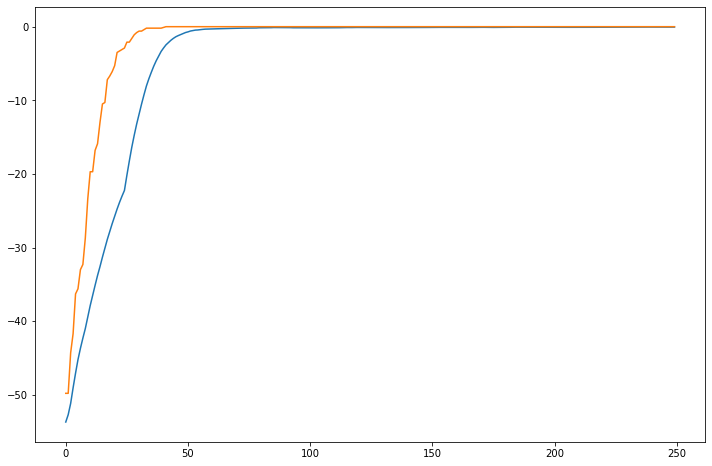

In [37]:
plt.figure(figsize=(12,8))
plt.plot(data['episode_reward_mean'])
plt.plot(data['episode_reward_max'])
plt.show()

In [39]:
def show_state(env):
    rest_locs = np.vstack(env.restaurant_loc)
#     order_locs = 
    # print rows
    for i in range(env.grid[0]):
        print("-" * (env.grid[1] * 5 + 1))
        row = []
        for j in range(env.grid[1]):
            if i == env.driver_loc[0] and j == env.driver_loc[1]:
                row.append("| D ")
            
            
#             if i == env.s[0] and j == self.s[1]:
#                 row.append("| X ")
#             elif i == self.pos_goal[0] and j == self.pos_goal[1]:
#                 row.append("| G ")
#             elif i == self.pos_trap[0] and j == self.pos_trap[1]:
#                 row.append("| T ")
            else:
                row.append("|   ")
        row.append("|  ")
        print(' '.join(row))
    print("-" * (self.dim[1] * 5 + 1))

array([3.        , 1.        , 2.        , 2.        , 4.        ,
       1.        , 0.        , 4.        , 1.        , 0.        ,
       1.        , 3.        , 0.        , 5.77287901, 1.        ,
       1.        , 2.        , 0.        , 0.        , 5.99302707,
       1.        , 1.        , 2.        , 1.        , 0.        ,
       5.28241111, 1.        , 0.        , 1.        , 4.        ,
       0.        , 5.32855736, 1.        , 1.        , 1.        ,
       4.        , 0.        , 5.04677205, 1.        , 0.        ,
       1.        , 2.        , 0.        , 5.87370451, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [45]:
rest_locs = np.vstack(env.restaurant_loc)
rest_locs

array([[3, 1],
       [2, 2]])

In [46]:
l = (3, 2)
np.where(rest_locs==l)

(array([0, 1]), array([0, 1]))